## Setup

In [103]:
from dslabs_functions import get_variable_types
from seaborn import heatmap
from dslabs_functions import HEIGHT, plot_multi_scatters_chart
from matplotlib.pyplot import figure, subplots, savefig, show, gcf
from dslabs_functions import plot_bar_chart
from dslabs_functions import set_chart_labels
from dslabs_functions import define_grid, HEIGHT
from matplotlib.figure import Figure
from numpy import ndarray
from dslabs_functions import *
from pandas import read_csv, DataFrame
from numpy import log
from pandas import Series
from scipy.stats import norm, expon, lognorm
from matplotlib.axes import Axes
from dslabs_functions import plot_multiline_chart

In [104]:
filename = "datasets/class_credit_score.csv"
file_tag = "credit_score"
data: DataFrame = read_csv(filename, na_values="", index_col="ID")

In [105]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option("display.max_colwidth", 200)

## Data Preparation

### Variable encoding

In [172]:
# Remove non-digits from age column and convert into numeric
data['Age'] = data['Age'].str.replace(r'[^0-9]+', '', regex=True)
data['Age'] = pd.to_numeric(data['Age'])

# Drop name column
data = data.drop(columns=['Name'])

# Leave only area code for SSN
data['SSN'] = data['SSN'].str.slice(stop=3)
data = data.rename(columns = {'SSN': 'SSN_Area_Code'})


above0_vars= ["Num_Bank_Accounts", "NumofDelayedPayment", "Delay_from_due_date"]

for var in above0_vars:
    data[var] = data[var].map(lambda x: max(x, 0))
data

AttributeError: Can only use .str accessor with string values!

In [107]:
import numpy as np

def process_loan_type_entry(entry):
    if not isinstance(entry, float):
        loan_types_split = []
        type_list = entry.replace(' and ', ' ')
        type_list = type_list.split(', ')
        for loan_type in type_list:
            loan_types_split.append('Loan_Type_' + loan_type.strip().replace(' ', '_').replace('-', '_'))
        return loan_types_split
    return np.nan

# Split loan types and reformat the strings

no_nans = data.dropna()
loan_values = no_nans['Type_of_Loan'].unique()

loan_types = []
for entry in loan_values:
    loan_types += process_loan_type_entry(entry)

loan_types_columns = set(loan_types)
loan_types_columns = list(loan_types_columns)


# Create columns and add to dataframe

def columns_count_occurrences(column_names, list_to_count):
    column_values = dict.fromkeys(column_names, 0)
    if isinstance(list_to_count, float):    # nan
        for key in column_values:
            column_values[key] = np.nan
    else:
        for item in list_to_count:
            column_values[item] += 1
    return column_values


data[loan_types_columns] = data.apply(lambda row: columns_count_occurrences(loan_types_columns, process_loan_type_entry(row['Type_of_Loan'])), axis='columns', result_type='expand')

data = data.drop(columns = ['Type_of_Loan'])

In [108]:
# Can we drop "num of loan"?

data = data.drop(columns = ['NumofLoan'])

In [109]:
# Convert credit history to months

import re

def convert_age_to_months(age):
    if isinstance(age, str):
        list_of_numbers = re.findall(r'\b\d+\b', age)
        if (len(list_of_numbers) != 2):
            print(list_of_numbers)
            raise Exception('Incorrect age input')
        years, months = int(list_of_numbers[0]), int(list_of_numbers[1])
        total_months = years * 12 + months
        return total_months
    return np.nan

data['Credit_History_Age_Months'] = data.apply(lambda row: convert_age_to_months(row['Credit_History_Age']), axis='columns', result_type='expand')
data = data.drop(columns=["Credit_History_Age"])

In [110]:
def dummify(df: DataFrame, vars_to_dummify: list[str]) -> DataFrame:
    other_vars: list[str] = [c for c in df.columns if not c in vars_to_dummify]

    enc = OneHotEncoder(
        handle_unknown="ignore", sparse_output=False, dtype="bool", drop="if_binary"
    )
    trans: ndarray = enc.fit_transform(df[vars_to_dummify])

    new_vars: ndarray = enc.get_feature_names_out(vars_to_dummify)

    dummy = DataFrame(trans, columns=new_vars, index=df.index)

    final_df: DataFrame = concat([df[other_vars], dummy], axis=1)
    return final_df

def encode_cyclic_variables(data: DataFrame, vars: list[str]):
    _data = data
    for v in vars:
        x_max: float = max(data[v])
        _data[v + "_sin"] = data[v].apply(lambda x: round(sin(2 * pi * x / x_max), 5))
        _data[v + "_cos"] = data[v].apply(lambda x: round(cos(2 * pi * x / x_max), 5))
    return _data


# Substitutions
credit_mix_enc: dict[str, int] = {"Good": 2, "Standard": 1, "Bad": 0}
credit_score_enc: dict[str, int] = {"Good": 1, "Poor": 0}
payment_min_amount_enc: dict[str, int] = {"Yes": 2, "NM": 1, "No": 0}
month_val: dict[str, float] = {
    "January": 0,
    "February": pi / 4,
    "March": 2 * pi / 4,
    "April": 3 * pi / 4,
    "May": pi,
    "June": - 3 * pi / 4,
    "July": - 2 * pi / 4,
    "August": - pi / 4
}

encoding: dict[str, dict[str, int]] = {
    "CreditMix": credit_mix_enc,
    "Month": month_val,
    "Credit_Score": credit_score_enc,
    "Payment_of_Min_Amount": payment_min_amount_enc
}


# Replace values on dataframe

data = data.replace(encoding, inplace=False)

vars = ["Occupation"]
data = dummify(data, vars)

data['Customer_ID'] = data.apply(lambda row: int(row['Customer_ID'].replace('CUS_', ''), 16), axis='columns', result_type='expand')

data = encode_cyclic_variables(data, ["Month"])
data = data.drop(columns=['Month'])

data["Payment_Behaviour_Spent"] = data["Payment_Behaviour"].map(lambda x: 0 if str(x).split('_')[0] == "Low" else 1 if str(x).split('_')[0] == "High" else np.nan)

data["Payment_Behaviour_Value"] = data["Payment_Behaviour"].map(lambda x: np.nan if len(str(x).split('_')) != 5 else 0 if str(x).split('_')[2] == "Small" else 1 if str(x).split('_')[2] == "Medium" else 2)
data = data.drop(columns=['Payment_Behaviour'])

### Missing value imputation

#### 2nd approach

In [111]:
# Phase 1: dropping MVs (records and variables)

data_mvi_1 = data.copy()

def mvi_by_dropping(
    data: DataFrame, min_pct_per_variable: float = 0.1, min_pct_per_record: float = 0.0
) -> DataFrame:
    # Deleting variables
    df: DataFrame = data.dropna(
        axis=1, thresh=data.shape[0] * min_pct_per_variable, inplace=False
    )
    # Deleting records
    df.dropna(axis=0, thresh=data.shape[1] * min_pct_per_record, inplace=True)

    return df


cols_before_drop = data_mvi_1.columns

# "thresh=N requires that a column has at least N non-NaNs to survive"
data_mvi_1 = mvi_by_dropping(data_mvi_1, min_pct_per_variable=0.1, min_pct_per_record=0.1)

print('Removed columns:')
print(list(set(cols_before_drop) - set(data_mvi_1.columns)))
print(data_mvi_1.shape)

Removed columns:
[]
(100000, 50)


In [112]:
# Phase 2: filling MVs

from numpy import ndarray
from pandas import concat
from sklearn.impute import SimpleImputer, KNNImputer
from dslabs_functions import get_variable_types, mvi_by_filling

def mvi_by_filling_per_column(data: DataFrame, cols: list, strategy: str = "mean") -> Series:
    # Possible strategies: "mean", "median", "most_frequent"
    if strategy != "knn":
        imp = SimpleImputer(strategy=strategy, copy=True)
        df = DataFrame(
            imp.fit_transform(data[cols]),
            columns=cols,
        )
        return df[cols]
    else:
        imp = KNNImputer(n_neighbors=5)
        imp.fit(data)
        ar: ndarray = imp.transform(data)
        df = DataFrame(ar, columns=data.columns, index=data.index)
        return df

df_to_change = data.copy()

df = mvi_by_filling_per_column(df_to_change, [], 'knn')

knn_cols = ['SSN_Area_Code', 'CreditMix', 'Amountinvestedmonthly', 'MonthlyBalance']
data_mvi_1[knn_cols] = df[knn_cols].copy()

knn_cols_3 = ['SSN_Area_Code', 'CreditMix', 'Amountinvestedmonthly', 'MonthlyBalance', 'Monthly_Inhand_Salary',
              'NumofDelayedPayment', 'ChangedCreditLimit', 'NumCreditInquiries', 'Credit_History_Age_Months', 'Payment_Behaviour_Spent', 'Payment_Behaviour_Value']
data_mvi_3 = df.copy()
data_mvi_3[knn_cols_3] = df[knn_cols_3]

# ----

median_cols = ['Monthly_Inhand_Salary', 'NumofDelayedPayment', 'ChangedCreditLimit', 'NumCreditInquiries', 'Credit_History_Age_Months']
data_mvi_1[median_cols] = mvi_by_filling_per_column(data_mvi_1, median_cols, 'median').values

mode_cols = ['Payment_Behaviour_Spent', 'Payment_Behaviour_Value']
data_mvi_1[mode_cols] = mvi_by_filling_per_column(data_mvi_1, mode_cols, 'most_frequent').values

# Type of loan
data_mvi_1[loan_types_columns] = mvi_by_filling_per_column(data_mvi_1, loan_types_columns, 'most_frequent').values

# Occupations
occupation_columns = ['Occupation_Accountant', 'Occupation_Architect', 'Occupation_Developer', 'Occupation_Doctor',
                      'Occupation_Engineer', 'Occupation_Entrepreneur', 'Occupation_Journalist', 'Occupation_Lawyer',
                       'Occupation_Manager', 'Occupation_Mechanic', 'Occupation_Media_Manager', 'Occupation_Musician',
                       'Occupation_Scientist', 'Occupation_Teacher', 'Occupation_Writer']

occupation_perc = []
for occ in occupation_columns:
    occupation_count = (data_mvi_1[occ] == True).sum()
    total_occupation = (data_mvi_1['Occupation_nan'] == False).sum()
    occupation_perc.append(occupation_count / total_occupation)

def choose_from_probability(column_names, probabilities):
    column_values = dict.fromkeys(column_names, False)
    chosen = np.random.choice(column_names, p=probabilities)
    column_values[chosen] = True
    return column_values

data_mvi_1[occupation_columns] = data_mvi_1.apply(lambda row: row[occupation_columns] if row['Occupation_nan'] == False else choose_from_probability(occupation_columns, occupation_perc), axis='columns', result_type='expand')
data_mvi_1 = data_mvi_1.drop(columns = ['Occupation_nan'])

In [113]:
data_mvi_3[occupation_columns] = data_mvi_3.apply(lambda row: row[occupation_columns] if row['Occupation_nan'] == False else choose_from_probability(occupation_columns, occupation_perc), axis='columns', result_type='expand')
data_mvi_3 = data_mvi_3.drop(columns = ['Occupation_nan'])
data_mvi_3[loan_types_columns] = mvi_by_filling_per_column(data_mvi_3, loan_types_columns, 'most_frequent').values

#### Comparison between the two approaches

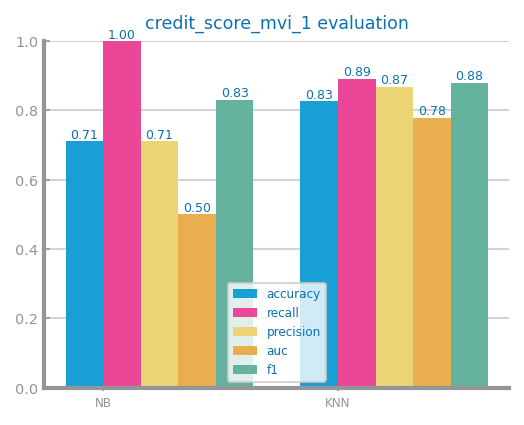

In [114]:
from numpy import ndarray
from pandas import DataFrame, read_csv
from matplotlib.pyplot import savefig, show, figure
from dslabs_functions import plot_multibar_chart, CLASS_EVAL_METRICS, run_NB, run_KNN
from sklearn.model_selection import train_test_split

file_tag = 'credit_score_mvi_1'
target = 'Credit_Score'
y = data_mvi_1[target]
X = data_mvi_1.drop(columns = target)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)


figure()
eval: dict[str, list] = evaluate_approach(train, test, target=target, metric="recall")
plot_multibar_chart(
    ["NB", "KNN"], eval, title=f"{file_tag} evaluation", percentage=True
)
savefig(f"images/{file_tag}_eval.png")
show()


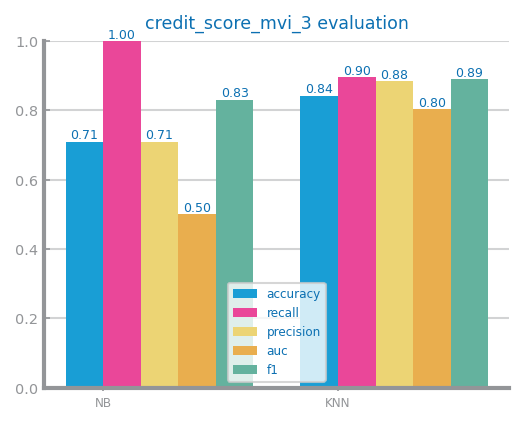

In [115]:
file_tag = 'credit_score_mvi_3'
target = 'Credit_Score'
y = data_mvi_3[target]
X = data_mvi_3.drop(columns = target)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)


figure()
eval: dict[str, list] = evaluate_approach(train, test, target=target, metric="recall")
plot_multibar_chart(
    ["NB", "KNN"], eval, title=f"{file_tag} evaluation", percentage=True
)
savefig(f"images/{file_tag}_eval.png")
show()

### Outliers treatment

Original data: (100000, 49)
Data after dropping outliers: (70605, 49)


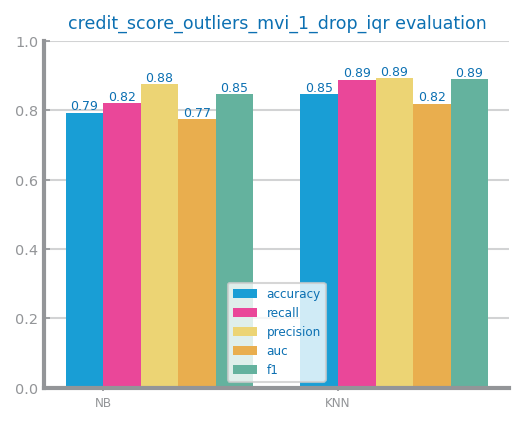

Data after replacing outliers: (100000, 49)


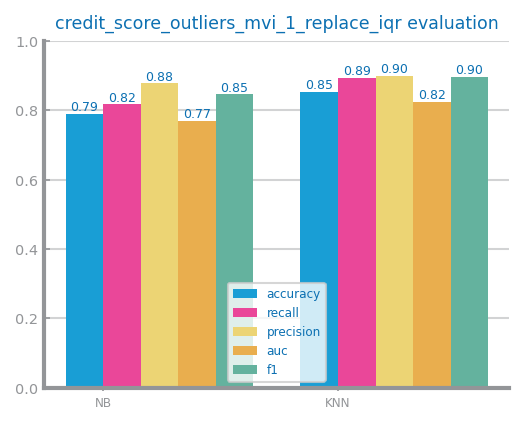

Data after truncating outliers: (100000, 49)


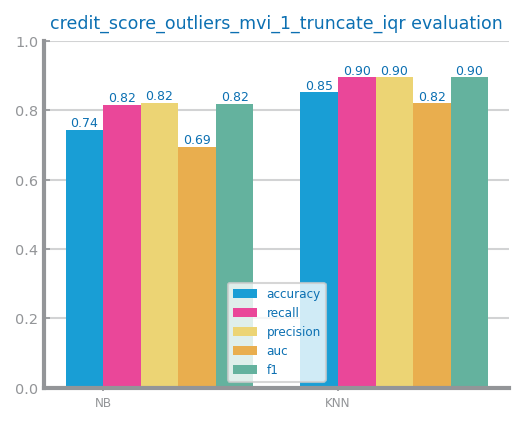

Data after dropping outliers: (70273, 49)


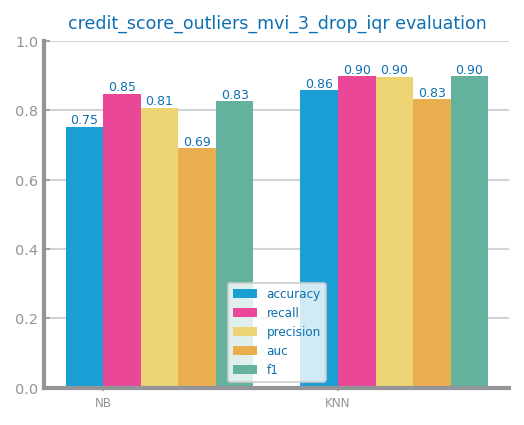

Data after replacing outliers: (100000, 49)


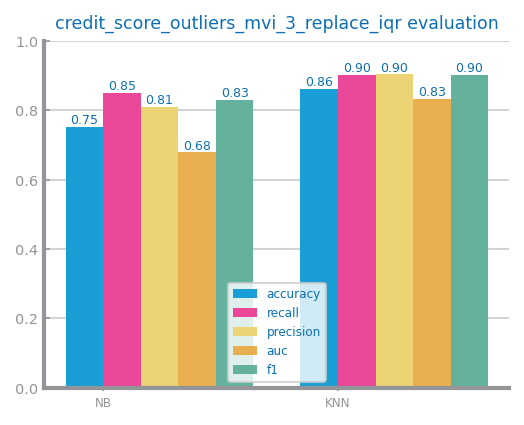

Data after truncating outliers: (100000, 49)


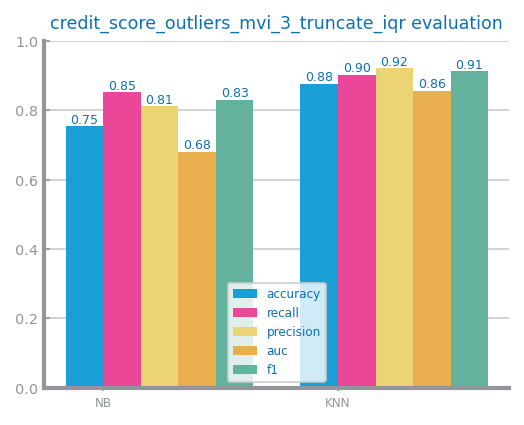

In [116]:
print(f"Original data: {data_mvi_3.shape}")

n_std: int = NR_STDEV
numeric_vars: list[str] = get_variable_types(data_mvi_3)["numeric"]

for dataset in ["mvi_1", "mvi_3"]:
# Alternative 1: Dropping Outliers

    df: DataFrame = data_mvi_3.copy(deep=True) if dataset == 'mvi_3' else data_mvi_1.copy(deep=True)
    file_tag = f'credit_score_outliers_{dataset}'
    target = 'Credit_Score'
    if numeric_vars is not None:
        
        summary5: DataFrame = data_mvi_3[numeric_vars].describe()
        for var in numeric_vars:
            top_threshold, bottom_threshold = determine_outlier_thresholds_for_var(
                summary5[var],
                std_based=False
            )
            outliers: Series = df[(df[var] > top_threshold) | (df[var] < bottom_threshold)]
            df.drop(outliers.index, axis=0, inplace=True)
        print(f"Data after dropping outliers: {df.shape}")

        
        y = df[target]
        X = df.drop(columns = target)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
        train = pd.concat([X_train, y_train], axis=1)
        test = pd.concat([X_test, y_test], axis=1)

        figure()
        eval: dict[str, list] = evaluate_approach(train, test, target=target, metric="recall")
        plot_multibar_chart(
            ["NB", "KNN"], eval, title=f"{file_tag}_drop_iqr evaluation", percentage=True
        )
        savefig(f"images/{file_tag}_drop_iqr_eval.png")
        show()
    else:
        print("There are no numeric variables")

    # Alternative 2: Replacing outliers with fixed value

    df: DataFrame = data_mvi_3.copy(deep=True) if dataset == 'mvi_3' else data_mvi_1.copy(deep=True)
    if [] != numeric_vars:
        for var in numeric_vars:
            top, bottom = determine_outlier_thresholds_for_var(summary5[var], std_based=False)
            median: float = df[var].median()
            df[var] = df[var].apply(lambda x: median if x > top or x < bottom else x)
        print("Data after replacing outliers:", df.shape)

        y = df[target]
        X = df.drop(columns = target)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
        train = pd.concat([X_train, y_train], axis=1)
        test = pd.concat([X_test, y_test], axis=1)


        figure()
        eval: dict[str, list] = evaluate_approach(train, test, target=target, metric="recall")
        plot_multibar_chart(
            ["NB", "KNN"], eval, title=f"{file_tag}_replace_iqr evaluation", percentage=True
        )
        savefig(f"images/{file_tag}_replace_iqr_eval.png")
        show()
    else:
        print("There are no numeric variables")


    # Alternative 3: Truncating outliers
    df: DataFrame = data_mvi_3.copy(deep=True) if dataset == 'mvi_3' else data_mvi_1.copy(deep=True)
    if [] != numeric_vars:
        for var in numeric_vars:
            top, bottom = determine_outlier_thresholds_for_var(summary5[var], std_based=False)
            df[var] = df[var].apply(
                lambda x: top if x > top else bottom if x < bottom else x
            )
        print("Data after truncating outliers:", df.shape)

        y = df[target]
        X = df.drop(columns = target)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
        train = pd.concat([X_train, y_train], axis=1)
        test = pd.concat([X_test, y_test], axis=1)


        figure()
        eval: dict[str, list] = evaluate_approach(train, test, target=target, metric="recall")
        plot_multibar_chart(
            ["NB", "KNN"], eval, title=f"{file_tag}_truncate_iqr evaluation", percentage=True
        )
        savefig(f"images/{file_tag}_trunc_iqr_eval.png")
        show()
    else:
        print("There are no numeric variables")



Original data: (100000, 49)
Data after dropping outliers: (42692, 49)


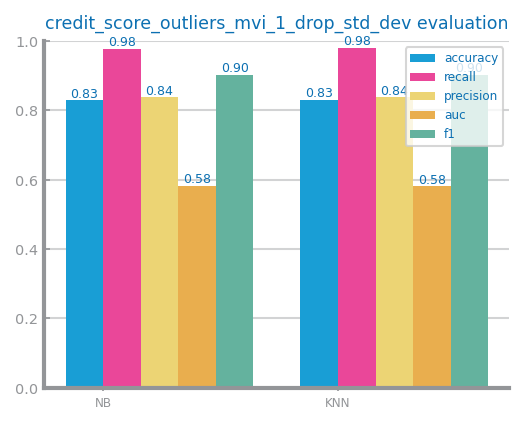

Data after replacing outliers: (100000, 49)


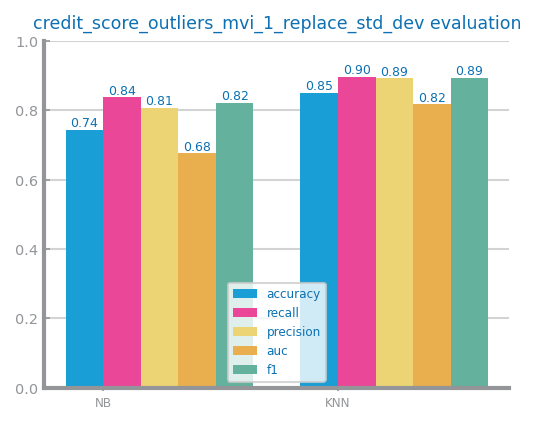

Data after truncating outliers: (100000, 49)


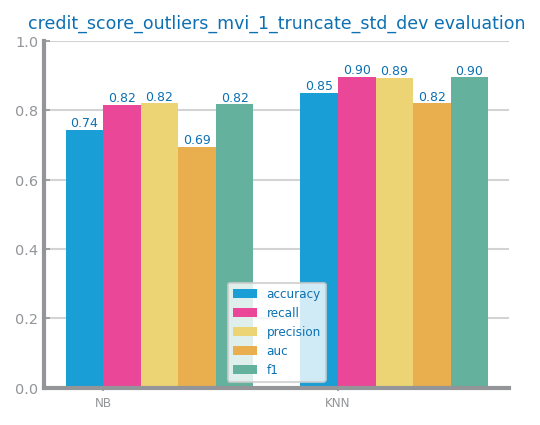

Data after dropping outliers: (39892, 49)


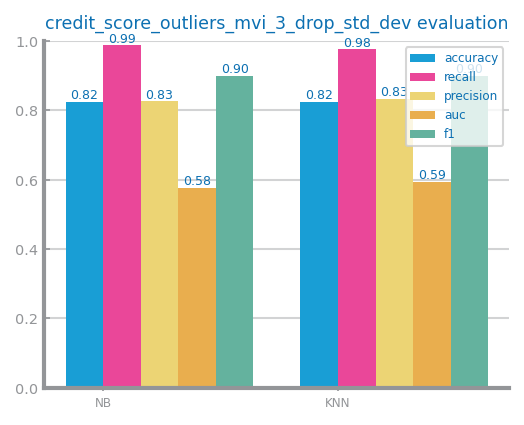

Data after replacing outliers: (100000, 49)


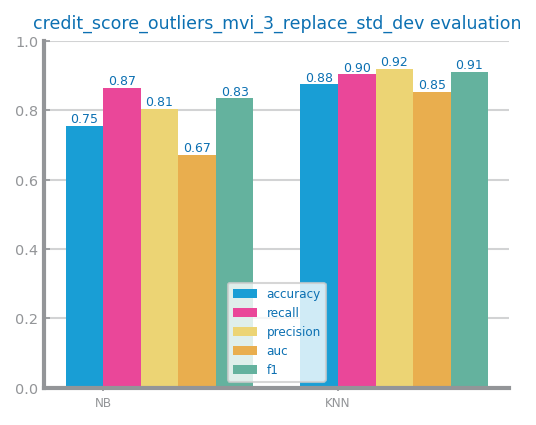

Data after truncating outliers: (100000, 49)


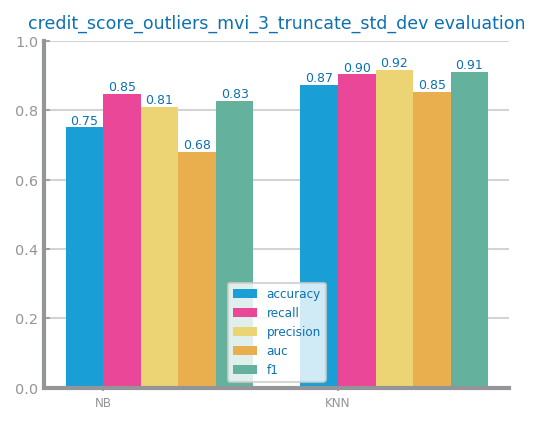

In [117]:
print(f"Original data: {data_mvi_3.shape}")

n_std: int = NR_STDEV
numeric_vars: list[str] = get_variable_types(data_mvi_3)["numeric"]


for dataset in ["mvi_1", "mvi_3"]:
# Alternative 1: Dropping Outliers

    df: DataFrame = data_mvi_3.copy(deep=True) if dataset == 'mvi_3' else data_mvi_1.copy(deep=True)
    file_tag = f'credit_score_outliers_{dataset}'
    target = 'Credit_Score'
    if numeric_vars is not None:
        
        summary5: DataFrame = data_mvi_3[numeric_vars].describe()
        for var in numeric_vars:
            top_threshold, bottom_threshold = determine_outlier_thresholds_for_var(
                summary5[var],
            )
            outliers: Series = df[(df[var] > top_threshold) | (df[var] < bottom_threshold)]
            df.drop(outliers.index, axis=0, inplace=True)
        print(f"Data after dropping outliers: {df.shape}")

        
        y = df[target]
        X = df.drop(columns = target)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
        train = pd.concat([X_train, y_train], axis=1)
        test = pd.concat([X_test, y_test], axis=1)


        figure()
        eval: dict[str, list] = evaluate_approach(train, test, target=target, metric="recall")
        plot_multibar_chart(
            ["NB", "KNN"], eval, title=f"{file_tag}_drop_std_dev evaluation", percentage=True
        )
        savefig(f"images/{file_tag}_drop_std_dev_eval.png")
        show()
    else:
        print("There are no numeric variables")

    # Alternative 2: Replacing outliers with fixed value

    df: DataFrame = data_mvi_3.copy(deep=True) if dataset == 'mvi_3' else data_mvi_1.copy(deep=True)
    if [] != numeric_vars:
        for var in numeric_vars:
            top, bottom = determine_outlier_thresholds_for_var(summary5[var])
            median: float = df[var].median()
            df[var] = df[var].apply(lambda x: median if x > top or x < bottom else x)
        print("Data after replacing outliers:", df.shape)

        y = df[target]
        X = df.drop(columns = target)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
        train = pd.concat([X_train, y_train], axis=1)
        test = pd.concat([X_test, y_test], axis=1)


        figure()
        eval: dict[str, list] = evaluate_approach(train, test, target=target, metric="recall")
        plot_multibar_chart(
            ["NB", "KNN"], eval, title=f"{file_tag}_replace_std_dev evaluation", percentage=True
        )
        savefig(f"images/{file_tag}_replace_std_dev_eval.png")
        show()
    else:
        print("There are no numeric variables")


    # Alternative 3: Truncating outliers
    df: DataFrame = data_mvi_3.copy(deep=True) if dataset == 'mvi_3' else data_mvi_1.copy(deep=True)
    if [] != numeric_vars:
        for var in numeric_vars:
            top, bottom = determine_outlier_thresholds_for_var(summary5[var], std_based=False)
            df[var] = df[var].apply(
                lambda x: top if x > top else bottom if x < bottom else x
            )
        print("Data after truncating outliers:", df.shape)

        y = df[target]
        X = df.drop(columns = target)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
        train = pd.concat([X_train, y_train], axis=1)
        test = pd.concat([X_test, y_test], axis=1)


        figure()
        eval: dict[str, list] = evaluate_approach(train, test, target=target, metric="recall")
        plot_multibar_chart(
            ["NB", "KNN"], eval, title=f"{file_tag}_truncate_std_dev evaluation", percentage=True
        )
        savefig(f"images/{file_tag}_trunc_std_dev_eval.png")
        show()
    else:
        print("There are no numeric variables")






In [165]:
#Assign the best to the best dataset mvi
import math
data_mvi_3_outliers_replace = data_mvi_3.copy()
summary5: DataFrame = data_mvi_3_outliers_replace[numeric_vars].describe()
above0_vars= ["Num_Bank_Accounts", "NumofDelayedPayment"]

for var in above0_vars:
    data_mvi_3_outliers_replace[var] = data_mvi_3_outliers_replace[var].map(lambda x: max(x, 0))

if [] != numeric_vars:
    for var in numeric_vars:
        top, bottom = determine_outlier_thresholds_for_var(summary5[var], std_based=False)
        median: float = data_mvi_3_outliers_replace[var].median()
        data_mvi_3_outliers_replace[var] = data_mvi_3_outliers_replace[var].apply(lambda x: median if x > top or x < bottom else x)
    print("Data after replacing outliers:", data_mvi_3_outliers_replace.shape)
    print(data_mvi_3_outliers_replace.head())
    
else:
    print("There are no numeric variables")


Data after replacing outliers: (100000, 49)
        Customer_ID   Age  SSN_Area_Code  Annual_Income  Monthly_Inhand_Salary  Num_Bank_Accounts  Num_Credit_Card  Interest_Rate  Delay_from_due_date  NumofDelayedPayment  ChangedCreditLimit  NumCreditInquiries  CreditMix  OutstandingDebt  CreditUtilizationRatio  Payment_of_Min_Amount  TotalEMIpermonth  Amountinvestedmonthly  MonthlyBalance  Credit_Score  Loan_Type_Home_Equity_Loan  Loan_Type_Mortgage_Loan  Loan_Type_Not_Specified  Loan_Type_Payday_Loan  Loan_Type_Auto_Loan  Loan_Type_Debt_Consolidation_Loan  Loan_Type_Personal_Loan  Loan_Type_Credit_Builder_Loan  Loan_Type_Student_Loan  Credit_History_Age_Months Occupation_Accountant Occupation_Architect Occupation_Developer Occupation_Doctor Occupation_Engineer Occupation_Entrepreneur Occupation_Journalist Occupation_Lawyer Occupation_Manager Occupation_Mechanic Occupation_Media_Manager Occupation_Musician Occupation_Scientist Occupation_Teacher Occupation_Writer  Month_sin  Month_cos  Pay

### Scaling

#### Alternative 1: Standard Scaler

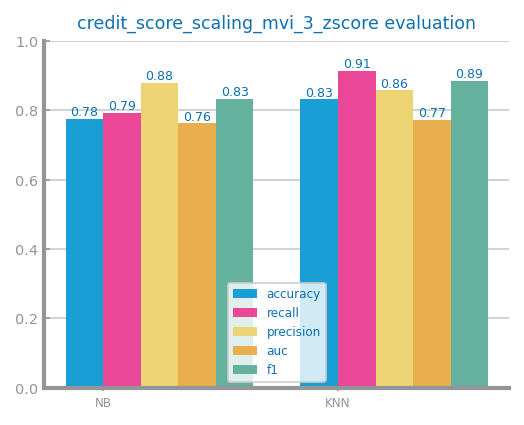

In [166]:
from pandas import read_csv, DataFrame, Series
from sklearn.preprocessing import StandardScaler

#Alternative 1: Standard Scalar

data_to_eval = data_mvi_3_outliers_replace.copy()

target = "Credit_Score"
file_tag = f'credit_score_scaling_mvi_3'

vars: list[str] = data_to_eval.columns.to_list()
target_data: Series = data_to_eval.pop(target)

transf: StandardScaler = StandardScaler(with_mean=True, with_std=True, copy=True).fit(
    data_to_eval
)
df_zscore = DataFrame(transf.transform(data_to_eval), index=data_to_eval.index)
vars.remove(target)
df_zscore.columns = vars
df_zscore[target] = target_data


# Charts for evaluation:

y = df_zscore[target]
X = df_zscore.drop(columns = target)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)
figure()
eval: dict[str, list] = evaluate_approach(train, test, target=target, metric="recall")
plot_multibar_chart(
    ["NB", "KNN"], eval, title=f"{file_tag}_zscore evaluation", percentage=True
)
savefig(f"images/{file_tag}_zscore_eval.png")
show()

#### Alternative 2: MinMax Scaler

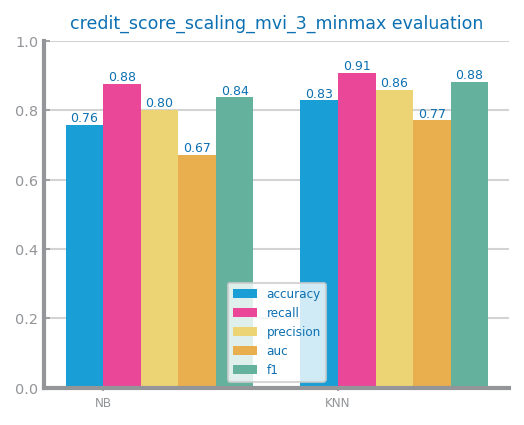

In [167]:
from sklearn.preprocessing import MinMaxScaler

data_to_eval = data_mvi_3_outliers_replace.copy()

vars: list[str] = data_to_eval.columns.to_list()
target_data: Series = data_to_eval.pop(target)

transf: MinMaxScaler = MinMaxScaler(feature_range=(0, 1), copy=True).fit(data_to_eval)
df_minmax = DataFrame(transf.transform(data_to_eval), index=data_to_eval.index)
vars.remove(target)
df_minmax.columns = vars
df_minmax[target] = target_data


# Charts for evaluation:

y = df_minmax[target]
X = df_minmax.drop(columns = target)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)
figure()
eval: dict[str, list] = evaluate_approach(train, test, target=target, metric="recall")
plot_multibar_chart(
    ["NB", "KNN"], eval, title=f"{file_tag}_minmax evaluation", percentage=True
)
savefig(f"images/{file_tag}_minmax_eval.png")
show()

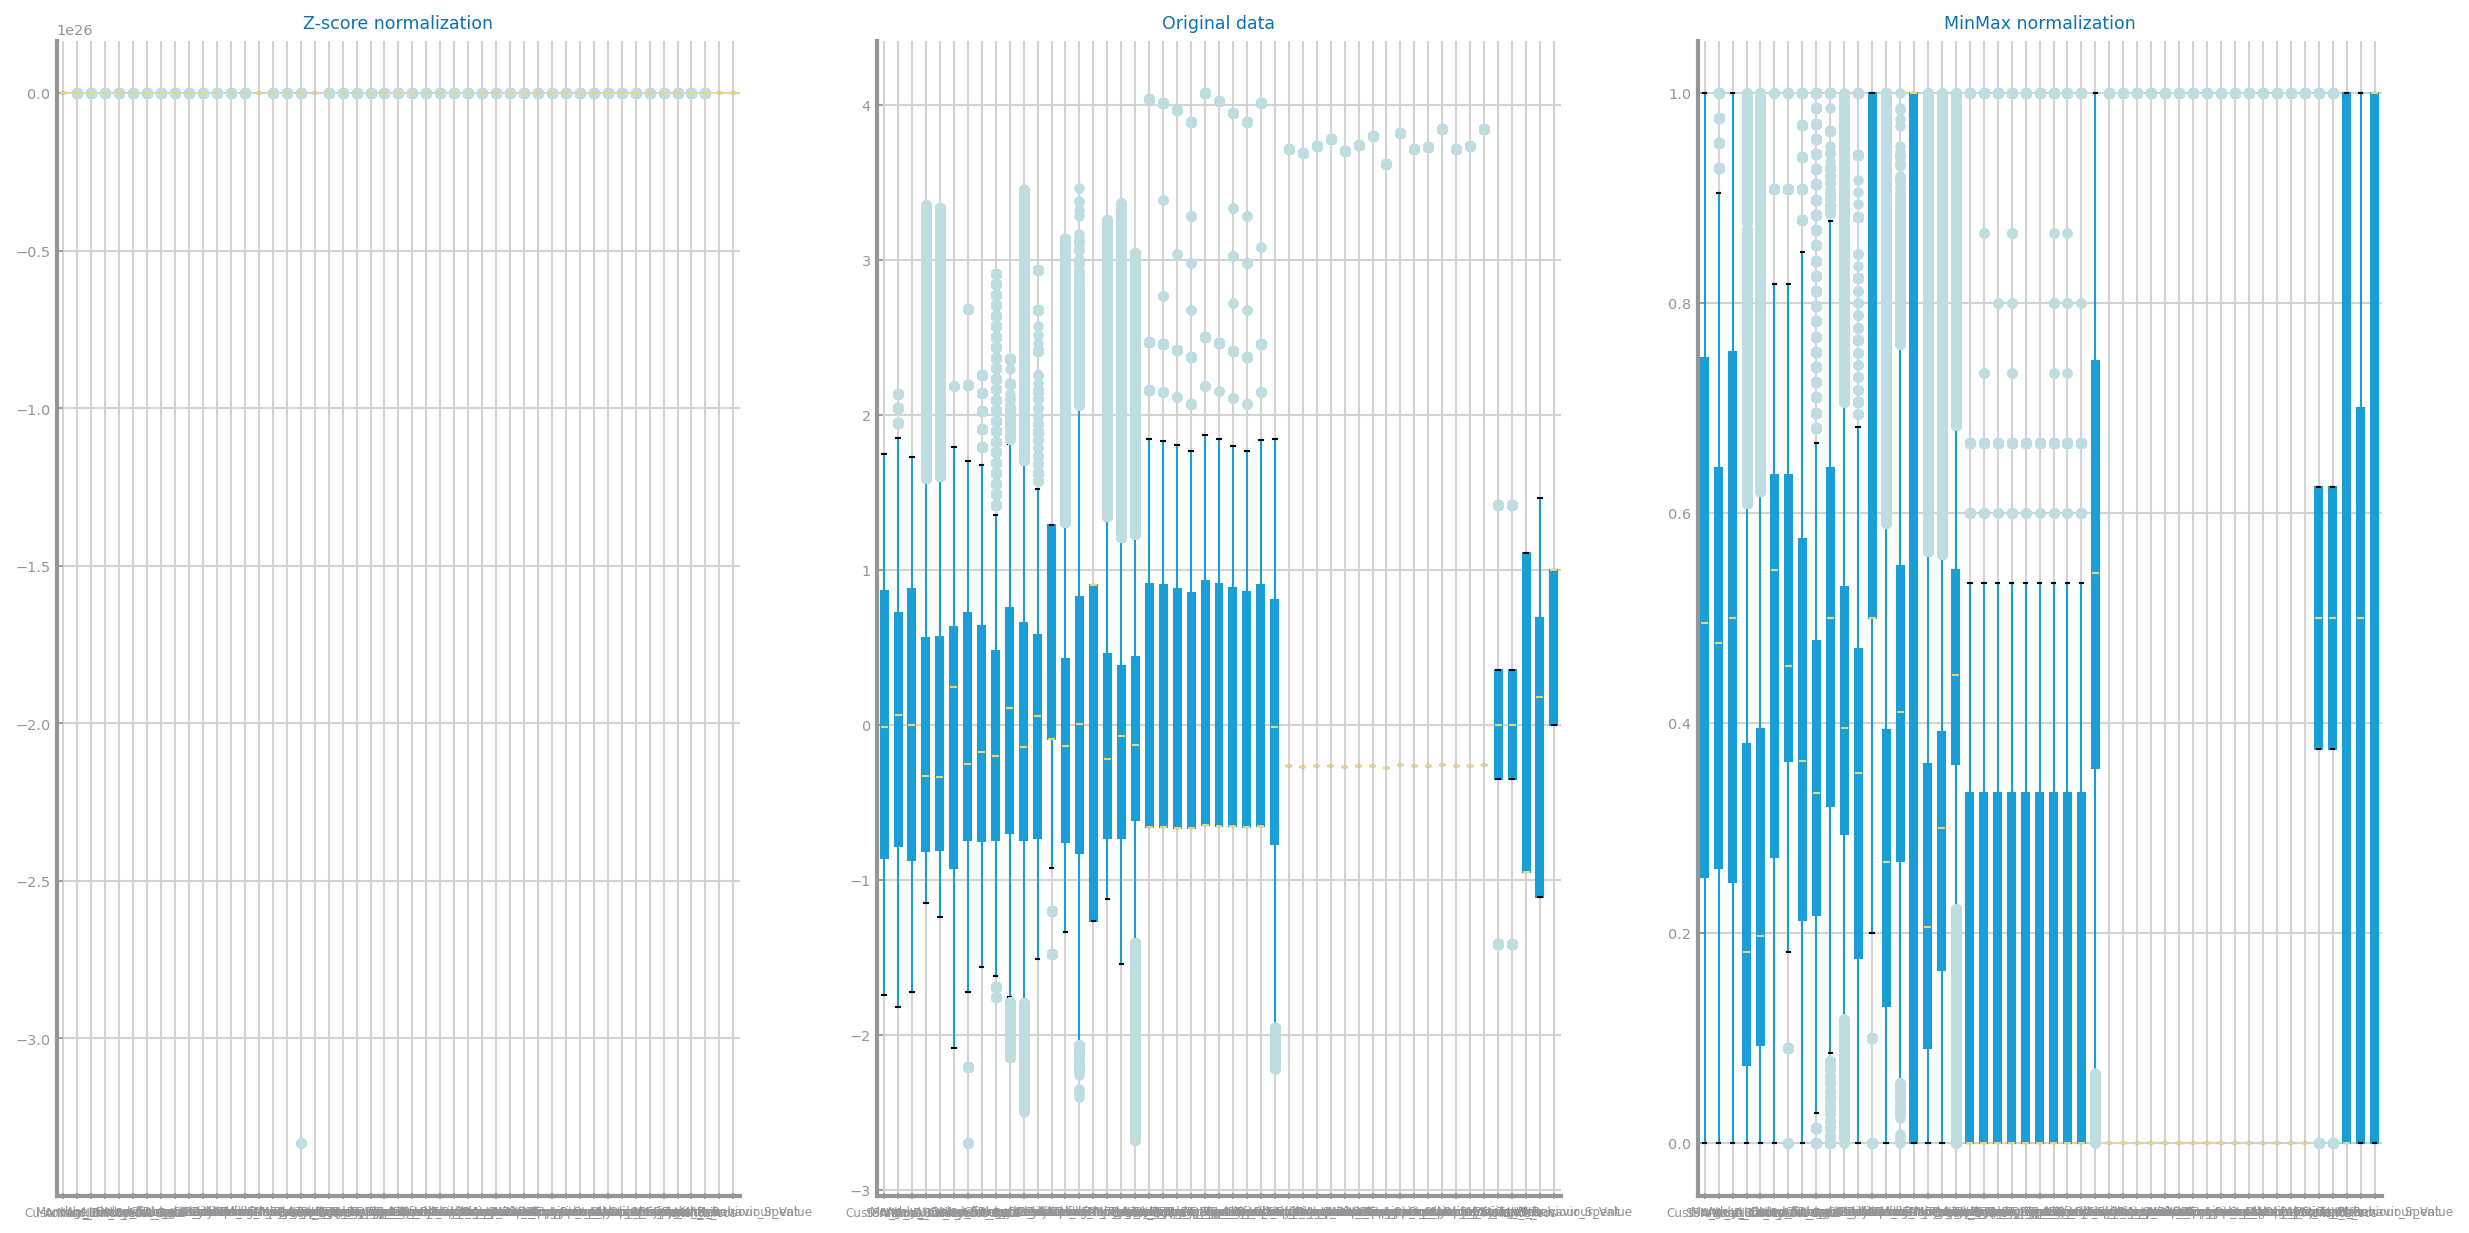

In [168]:
from matplotlib.pyplot import subplots, show

# Visualize boxplots real quick...

data_to_eval = data_mvi_3_outliers_replace.copy()
vars: list[str] = data_to_eval.columns.to_list()
target_data: Series = data_to_eval.pop(target)
transf: MinMaxScaler = MinMaxScaler(feature_range=(0, 1), copy=True).fit(data_to_eval)
df_minmax = DataFrame(transf.transform(data_to_eval), index=data_to_eval.index)
df_zscore[target] = target_data
df_zscore.columns = vars
data_to_eval = data_mvi_3_outliers_replace.copy()
vars: list[str] = data_to_eval.columns.to_list()
target_data: Series = data_to_eval.pop(target)
transf: MinMaxScaler = MinMaxScaler(feature_range=(0, 1), copy=True).fit(data_to_eval)
df_minmax = DataFrame(transf.transform(data_to_eval), index=data_to_eval.index)
df_minmax[target] = target_data
df_minmax.columns = vars


fig, axs = subplots(1, 3, figsize=(20, 10), squeeze=False)
axs[0, 1].set_title("Original data")
data.boxplot(ax=axs[0, 0])
axs[0, 0].set_title("Z-score normalization")
df_zscore.boxplot(ax=axs[0, 1])
axs[0, 2].set_title("MinMax normalization")
df_minmax.boxplot(ax=axs[0, 2])
show()

#### Assign best result

In [170]:
data_after_scaling = data_mvi_3_outliers_replace

### Balancing

#### Before balancing

Minority class= 0.0 : 28998
Majority class= 1.0 : 71002
Proportion: 0.41 : 1


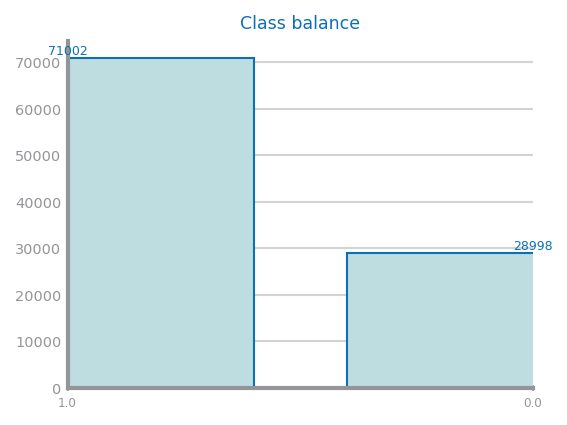

In [139]:
from pandas import read_csv, concat, DataFrame, Series
from matplotlib.pyplot import figure, show
from dslabs_functions import plot_bar_chart

data_to_balance = data_after_scaling.copy()

target_count: Series = data_to_balance[target].value_counts()
positive_class = target_count.idxmin()
negative_class = target_count.idxmax()

print("Minority class=", positive_class, ":", target_count[positive_class])
print("Majority class=", negative_class, ":", target_count[negative_class])
print(
    "Proportion:",
    round(target_count[positive_class] / target_count[negative_class], 2),
    ": 1",
)
values: dict[str, list] = {
    "Original": [target_count[positive_class], target_count[negative_class]]
}

figure()
plot_bar_chart(
    target_count.index.to_list(), target_count.to_list(), title="Class balance"
)
show()

In [140]:
df_positives: Series = data_to_balance[data_to_balance[target] == positive_class]
df_negatives: Series = data_to_balance[data_to_balance[target] == negative_class]

#### Approach 1: Undersampling

With a huge dataset, and consequently a considerable number of positve records, we can use an undersampling strategy, keeping the positive records and sampling the negative ones to balance the final distribution

In [141]:
df_neg_sample: DataFrame = DataFrame(df_negatives.sample(len(df_positives)))
df_under: DataFrame = concat([df_positives, df_neg_sample], axis=0)

print("Minority class=", positive_class, ":", len(df_positives))
print("Majority class=", negative_class, ":", len(df_neg_sample))
print("Proportion:", round(len(df_positives) / len(df_neg_sample), 2), ": 1")

Minority class= 0.0 : 28998
Majority class= 1.0 : 28998
Proportion: 1.0 : 1


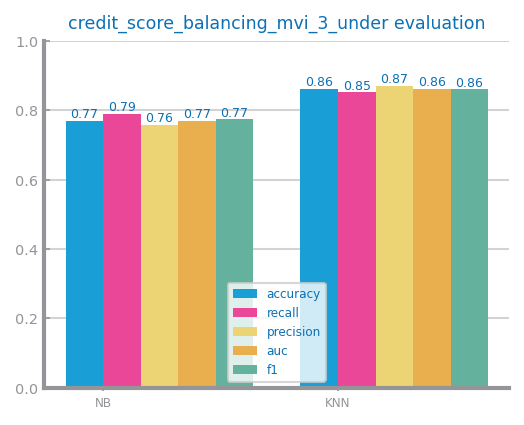

In [142]:
# Evaluate

data_to_eval = df_under.copy()
file_tag = f'credit_score_balancing_mvi_3_'

y = data_to_eval[target]
X = data_to_eval.drop(columns = target)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)
figure()
eval: dict[str, list] = evaluate_approach(train, test, target=target, metric="recall")
plot_multibar_chart(
    ["NB", "KNN"], eval, title=f"{file_tag}under evaluation", percentage=True
)
savefig(f"images/{file_tag}under_eval.png")
show()

#### Approach 2: Oversampling

In the presence of a small number of positive records, we need to apply oversampling, in order to create a larger set to support the training step.

In [143]:
df_pos_sample: DataFrame = DataFrame(
    df_positives.sample(len(df_negatives), replace=True)
)
df_over: DataFrame = concat([df_pos_sample, df_negatives], axis=0)

print("Minority class=", positive_class, ":", len(df_pos_sample))
print("Majority class=", negative_class, ":", len(df_negatives))
print("Proportion:", round(len(df_pos_sample) / len(df_negatives), 2), ": 1")

Minority class= 0.0 : 71002
Majority class= 1.0 : 71002
Proportion: 1.0 : 1


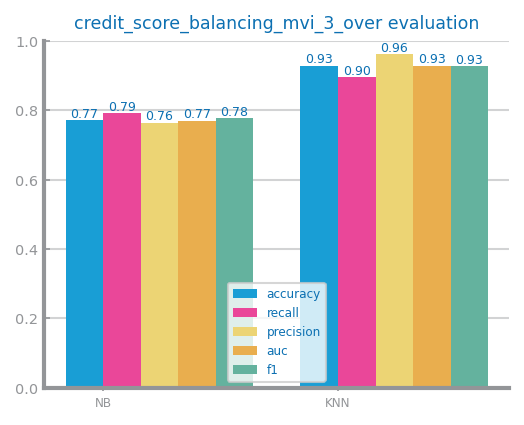

In [144]:
# Evaluate

data_to_eval = df_over.copy()
file_tag = f'credit_score_balancing_mvi_3_'

y = data_to_eval[target]
X = data_to_eval.drop(columns = target)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)
figure()
eval: dict[str, list] = evaluate_approach(train, test, target=target, metric="recall")
plot_multibar_chart(
    ["NB", "KNN"], eval, title=f"{file_tag}over evaluation", percentage=True
)
savefig(f"images/{file_tag}over_eval.png")
show()

#### Approach 3: SMOTE

The oversample is created from the minority class, by artificially creating new records in the neighborhood of the positive records.

In [145]:
from numpy import ndarray
from pandas import Series
from imblearn.over_sampling import SMOTE

RANDOM_STATE = 42

smote: SMOTE = SMOTE(sampling_strategy="minority", random_state=RANDOM_STATE)
y = data_to_balance.pop(target).values
X: ndarray = data_to_balance.values
smote_X, smote_y = smote.fit_resample(X, y)
df_smote: DataFrame = concat([DataFrame(smote_X), DataFrame(smote_y)], axis=1)
df_smote.columns = list(data_to_balance.columns) + [target]

smote_target_count: Series = Series(smote_y).value_counts()
print("Minority class=", positive_class, ":", smote_target_count[positive_class])
print("Majority class=", negative_class, ":", smote_target_count[negative_class])
print(
    "Proportion:",
    round(smote_target_count[positive_class] / smote_target_count[negative_class], 2),
    ": 1",
)
print(df_smote.shape)

Minority class= 0.0 : 71002
Majority class= 1.0 : 71002
Proportion: 1.0 : 1
(142004, 49)


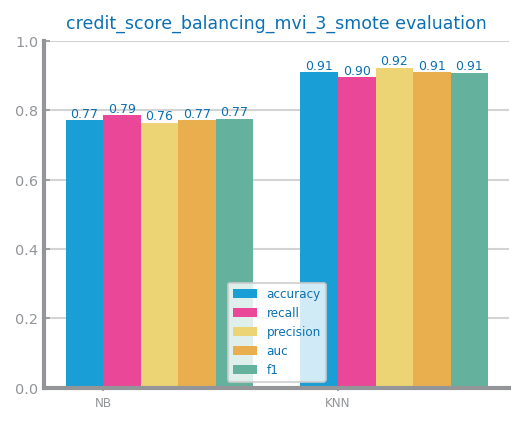

In [146]:
# Evaluate

data_to_eval = df_smote.copy()
file_tag = f'credit_score_balancing_mvi_3_'

y = data_to_eval[target]
X = data_to_eval.drop(columns = target)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)
figure()
eval: dict[str, list] = evaluate_approach(train, test, target=target, metric="recall")
plot_multibar_chart(
    ["NB", "KNN"], eval, title=f"{file_tag}smote evaluation", percentage=True
)
savefig(f"images/{file_tag}smote_eval.png")
show()

### Feature selection

Final

In [171]:
data_after_scaling.to_csv('csv-results/credit-score-after-preparation.csv')